In [16]:
%matplotlib inline
import os
import sys
sys.path.insert(0, os.path.abspath('../src'))
from tqdm import tqdm
from warnings import warn

import numpy as np
import pandas as pd

from IPython.display import Markdown, display
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from common_utils import compute_metrics
from aif360.algorithms.inprocessing import PrejudiceRemover
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.postprocessing.reject_option_classification\
        import RejectOptionClassification

from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler


# Import employment dataset 
from EmploymentDataset import EmploymentDataset
from util import preprocess_employment

In [95]:
privileged_groups = [{'Race': 1}]
unprivileged_groups = [{'Race': 0}]

# Fairness penalty paramenters
eta = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0] 


prejudice_remover = PrejudiceRemover(eta=22, sensitive_attr = 'Race', class_attr='EmploymentStatus')
prejudice_no_penalty = PrejudiceRemover(eta= 1, sensitive_attr = 'Race', class_attr='EmploymentStatus')
 
# Import the dataset
dataset_orig = preprocess_employment()

# Split into train and test (70% train, 15% validate & 15% train)
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#train = dataset_orig_train.copy(deepcopy=True)
#test = dataset_orig_vt.copy(deepcopy=True)
train, test = dataset_orig.split([0.8], shuffle=True)

# Measures the difference between favorable outcome for the unprivileged group to the privileged group
metric_name = "Statistical parity difference"

# Upper and lower bound of constraint on the metric value
metric_ub = 0.05
metric_lb = -0.05
        
#random seed for calibrated equal odds prediction
np.random.seed(1)

# Optimization metrics available for ROC. Have to be one of these.
allowed_metrics = ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]


if metric_name not in allowed_metrics:
    raise ValueError("Metric name should be one of allowed metrics")

In [96]:
# Display dataset shape, privileged/unprivileged classes and attribute
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

df = dataset_orig_train.convert_to_dataframe()


#### Training Dataset shape

(56827, 42)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Sex', 'Race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Dataset feature names

['Sex', 'Race', 'Region=0', 'Region=1', 'Region=2', 'Region=3', 'Married=0', 'Married=1', 'Married=2', 'Married=3', 'Married=4', 'Education=0', 'Education=1', 'Education=2', 'Education=3', 'Education=4', 'Education=5', 'Education=6', 'Education=7', 'Citizenship=Native', 'Citizenship=Non Native', 'Industry=0', 'Industry=1', 'Industry=2', 'Industry=3', 'Industry=4', 'Industry=5', 'Industry=6', 'Industry=7', 'Industry=8', 'Industry=9', 'Industry=10', 'Industry=11', 'Industry=12', 'Industry=13', 'age_by_decade=10', 'age_by_decade=20', 'age_by_decade=30', 'age_by_decade=40', 'age_by_decade=50', 'age_by_decade=60', 'age_by_decade=>=70']


In [97]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
display(Markdown('A value of 1 indicates full discrimination, while -1 is the reverse discrimination case. A value close to 0 is favorable. (1 - mean difference)'))
print(f'The difference in mean outcomes between unprivileged and privileged groups is { metric_orig_train.mean_difference():.6f}')

#### Original training dataset

A value of 1 indicates full discrimination, while -1 is the reverse discrimination case. A value close to 0 is favorable. (1 - mean difference)

The difference in mean outcomes between unprivileged and privileged groups is -0.097312


In [98]:
standard_scaler = StandardScaler()
train.features = standard_scaler.fit_transform(train.features)
test.features = standard_scaler.transform(test.features)
metric_scaled_train = BinaryLabelDatasetMetric(train, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
display(Markdown("#### Scaled dataset - Verify that the scaling does not affect the group label statistics"))
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_train.mean_difference())
metric_scaled_test = BinaryLabelDatasetMetric(test, 
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_scaled_test.mean_difference())

#### Scaled dataset - Verify that the scaling does not affect the group label statistics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.094392
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.088689


In [99]:
# Train model with eta = 10
prejudice_remover.fit(train)
# Apply the prejudice remover model to test data
dataset_train_transformed = prejudice_remover.predict(train)
dataset_test_transformed = prejudice_remover.predict(test)

# Standardize data to normal disrtibution, i.e transform columns to a common scale (numerical values)
X_train = standard_scaler.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()

lmod = LogisticRegression()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

# index to positive class
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

# Get predictions and labels
dataset_orig_train_pred = dataset_orig_train.copy(deepcopy=True)
dataset_orig_train_pred.labels = y_train_pred

In [100]:
###### Debiasing begins here (Prejudice) ############


display(Markdown("## Prejudice Remover with fairness constraints (eta = 10) - dataset metrics"))

# Metrics for the dataset from model with debiasing
display(Markdown("#### Model with debiasing - dataset metrics"))
metric_dataset_prejudiceremover_train = BinaryLabelDatasetMetric(dataset_train_transformed, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_train.mean_difference())

metric_dataset_prejudiceremover_test = BinaryLabelDatasetMetric(dataset_test_transformed, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_dataset_prejudiceremover_test.mean_difference())

display(Markdown("#### Model with biasing - classification metrics (test set)"))
classified_metric_prejudiceremover_test = ClassificationMetric(test, 
                                                 dataset_test_transformed,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
print("Test set: Classification accuracy = %f" % classified_metric_prejudiceremover_test.accuracy())
TPR = classified_metric_prejudiceremover_test.true_positive_rate()
TNR = classified_metric_prejudiceremover_test.true_negative_rate()
bal_acc_predjudiceremover_test = 0.5*(TPR+TNR)
print("Balanced classification accuracy = %f" % bal_acc_predjudiceremover_test)
print("Test set: Disparate impact = %f" % classified_metric_prejudiceremover_test.disparate_impact())
print("Test set: Equal opportunity difference = %f" % classified_metric_prejudiceremover_test.equal_opportunity_difference())
print("Test set: Statistical parity difference = %f" % classified_metric_prejudiceremover_test.mean_difference())
print("Test set: Average odds difference = %f" % classified_metric_prejudiceremover_test.average_odds_difference())
print("Test set: Theil_index = %f" % classified_metric_prejudiceremover_test.theil_index())

## Prejudice Remover with fairness constraints (eta = 10) - dataset metrics

#### Model with debiasing - dataset metrics

Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.022634
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.024349


#### Model with biasing - classification metrics (test set)

Test set: Classification accuracy = 0.851019
Balanced classification accuracy = 0.753391
Test set: Disparate impact = 0.970476
Test set: Equal opportunity difference = -0.023592
Test set: Statistical parity difference = -0.024349
Test set: Average odds difference = 0.051657
Test set: Theil_index = 0.077232


**Obtain scores for validation and test sets**

In [101]:
# Same procedure, but for validation set
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = standard_scaler.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = standard_scaler.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [102]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)


Best balanced accuracy (no fairness constraints) = 0.8097
Optimal classification threshold (no fairness constraints) = 0.7326


In [103]:
# Use upper and lower bound constraint for tweaking (metric_ub and metric_lb)
ROC = RejectOptionClassification(unprivileged_groups=unprivileged_groups, 
                                 privileged_groups=privileged_groups, 
                                 low_class_thresh=0.01, high_class_thresh=0.99,
                                  num_class_thresh=100, num_ROC_margin=50,
                                  metric_name=metric_name,
                                  metric_ub=metric_ub, metric_lb=metric_lb)
ROC = ROC.fit(dataset_orig_valid, dataset_orig_valid_pred)

print("Optimal classification threshold (with fairness constraints) = %.4f" % ROC.classification_threshold)
print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

Optimal classification threshold (with fairness constraints) = 0.6831
Optimal ROC margin = 0.0776


In [104]:
# Metrics for the validation set (no fairnesss constraints)
fav_inds = dataset_orig_valid_pred.scores > best_class_thresh
dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

display(Markdown("#### Validation set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_valid_bef = compute_metrics(dataset_orig_valid, dataset_orig_valid_pred, 
                unprivileged_groups, privileged_groups)

# Metrics for the validation set (with fairness constraints)

# Transform the validation set
dataset_transf_valid_pred = ROC.predict(dataset_orig_valid_pred)

display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_valid_aft = compute_metrics(dataset_orig_valid, dataset_transf_valid_pred, 
                unprivileged_groups, privileged_groups)

#### Validation set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.8097
Statistical parity difference = -0.1352
Disparate impact = 0.8069
Average odds difference = -0.0663
Equal opportunity difference = -0.0918
Theil index = 0.1607


##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.8064
Statistical parity difference = -0.0468
Disparate impact = 0.9312
Average odds difference = 0.0205
Equal opportunity difference = -0.0010
Theil index = 0.1649


In [105]:
# Testing: Check if the metric optimized has not become worse
assert np.abs(metric_valid_aft[metric_name]) <= np.abs(metric_valid_bef[metric_name])

# Predictions from test set

In [106]:
# Metrics for the test set (no fairness constraints)
fav_inds = dataset_orig_test_pred.scores > best_class_thresh
dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label


display(Markdown("#### Test set"))
display(Markdown("##### Raw predictions - No fairness constraints, only maximizing balanced accuracy"))

metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                unprivileged_groups, privileged_groups)

# Apply ROC technique

# Metrics for the transformed test set
dataset_transf_test_pred = ROC.predict(dataset_orig_test_pred)

display(Markdown("#### Test set"))
display(Markdown("##### Transformed predictions - With fairness constraints"))
metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                unprivileged_groups, privileged_groups)






metric_orig_pred = BinaryLabelDatasetMetric(dataset_transf_test_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print(f'The difference in mean outcomes between unprivileged and privileged groups is { metric_orig_pred.mean_difference():.6f}')

#### Test set

##### Raw predictions - No fairness constraints, only maximizing balanced accuracy

Balanced accuracy = 0.8014
Statistical parity difference = -0.1184
Disparate impact = 0.8317
Average odds difference = -0.0622
Equal opportunity difference = -0.0922
Theil index = 0.1637


#### Test set

##### Transformed predictions - With fairness constraints

Balanced accuracy = 0.7981
Statistical parity difference = -0.0334
Disparate impact = 0.9510
Average odds difference = 0.0207
Equal opportunity difference = -0.0049
Theil index = 0.1688
The difference in mean outcomes between unprivileged and privileged groups is -0.033447


[0.         0.         0.         ... 0.99690828 0.99828238 1.        ]
[0.00000000e+00 3.23729362e-04 1.18700766e-03 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
[1.99723471e+00 9.97234706e-01 9.96326960e-01 ... 4.43070639e-02
 3.91630101e-02 4.75594632e-05]
<class 'numpy.float64'>


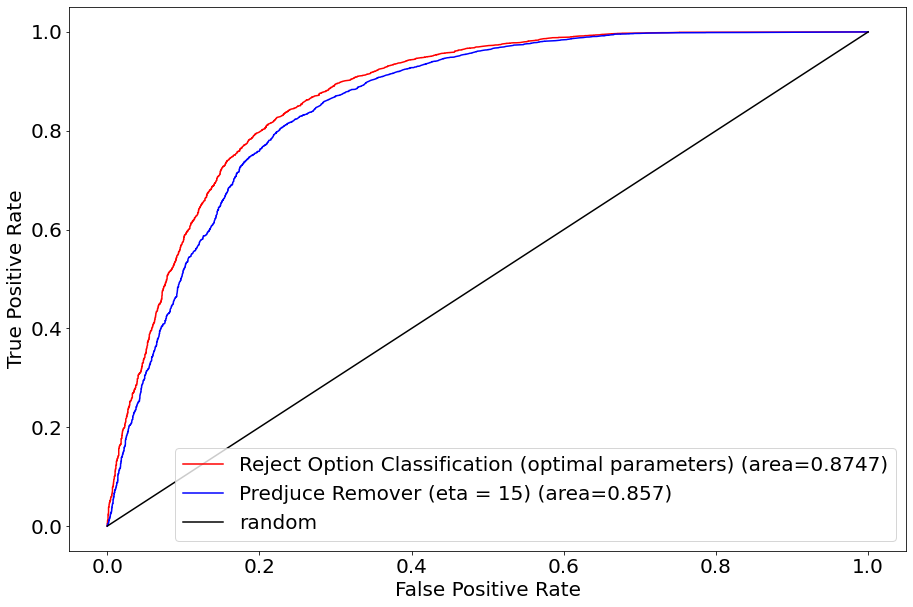

False positive rate: %s 0.00034352456200618345
True positive rate: %s 0.011006798316607317


In [107]:
fpr, tpr, thresholds = roc_curve(dataset_orig_test.labels, dataset_orig_test_pred.scores)
print(f'{fpr}\n{tpr}\n{thresholds}')

fpr_RF, tpr_RF, thresholds_RF = roc_curve(dataset_orig_test.labels, dataset_orig_test_pred.scores, pos_label=1)
fpr_RF_pr, tpr_RF_pr, thresholds_RF_pr = roc_curve(test.labels, dataset_test_transformed.scores, pos_label=1)

print(type(fpr_RF[0]))
plt.figure(figsize=(15,10))
plt.plot(fpr_RF, tpr_RF,'r-',label = f'Reject Option Classification (optimal parameters) (area={round(roc_auc_score(dataset_orig_test.labels, dataset_orig_test_pred.scores), 4)})')
plt.plot(fpr_RF_pr, tpr_RF_pr,'b-',label = f'Predjuce Remover (eta = 15) (area={round(roc_auc_score(test.labels, dataset_test_transformed.scores), 4)})')
plt.plot([0,1],[0,1],'k-',label='random')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.rcParams.update({'font.size': 20})
plt.savefig("predjuce_roc_curve_past_15_eta.svg")
plt.show()
print("False positive rate: %s", fpr_RF[18])
print("True positive rate: %s", tpr_RF[18])
### ROC END

In [108]:
display(Markdown("#### Running the algorithm for different eta values"))

accuracies, false_discovery_rates, statistical_rates, average_odds, disparate_impact, equal_opportunity, theil_index = [], [],\
[], [], [], [], []
sensitive_attribute = "Race"

eta = [1.0, 2.0, 3.0, 4.0, 5.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0] 

all_eta = np.linspace(0.0, 30, 30)
for e in range(31):
    print("eta: %.2f" % e)
    debiased_model = PrejudiceRemover(eta=e, sensitive_attr=sensitive_attribute)
    debiased_model.fit(train)
    
    dataset_debiasing_test = debiased_model.predict(test)
    predictions = dataset_debiasing_test.labels
    predictions = [1 if y == train.favorable_label else -1 for y in predictions]
    
    classified_metric_prejudiceremover_test = ClassificationMetric(test, 
                                                 dataset_debiasing_test,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    acc = 0.5*(classified_metric_prejudiceremover_test.true_positive_rate()+classified_metric_prejudiceremover_test.true_negative_rate())
    sp =  classified_metric_prejudiceremover_test.mean_difference()
    fr = classified_metric_prejudiceremover_test.false_discovery_rate()
    eo = classified_metric_prejudiceremover_test.equal_opportunity_difference()
    ao = classified_metric_prejudiceremover_test.average_odds_difference()
    di = classified_metric_prejudiceremover_test.disparate_impact()
    ti = classified_metric_prejudiceremover_test.theil_index()
    print("accuracy: %.2f" % acc)
    print("fdr: %.2f" % fr)
    print("statistical parity: %.2f" % sp)
    
    ## Testing
    #assert (fr >= unconstrainedFDR)
    
    accuracies.append(acc)
    false_discovery_rates.append(fr)
    statistical_rates.append(sp)
    equal_opportunity.append(eo)
    average_odds.append(ao)
    disparate_impact.append(di)
    theil_index.append(ti)
    

#### Running the algorithm for different eta values

eta: 0.00
accuracy: 0.78
fdr: 0.12
statistical parity: -0.11
eta: 1.00
accuracy: 0.78
fdr: 0.12
statistical parity: -0.09
eta: 2.00
accuracy: 0.77
fdr: 0.12
statistical parity: -0.08
eta: 3.00
accuracy: 0.77
fdr: 0.12
statistical parity: -0.08
eta: 4.00
accuracy: 0.77
fdr: 0.12
statistical parity: -0.07
eta: 5.00
accuracy: 0.77
fdr: 0.12
statistical parity: -0.05
eta: 6.00
accuracy: 0.77
fdr: 0.12
statistical parity: -0.06
eta: 7.00
accuracy: 0.77
fdr: 0.12
statistical parity: -0.06
eta: 8.00
accuracy: 0.77
fdr: 0.12
statistical parity: -0.05
eta: 9.00
accuracy: 0.76
fdr: 0.12
statistical parity: -0.05
eta: 10.00
accuracy: 0.76
fdr: 0.12
statistical parity: -0.05
eta: 11.00
accuracy: 0.76
fdr: 0.12
statistical parity: -0.05
eta: 12.00
accuracy: 0.76
fdr: 0.12
statistical parity: -0.04
eta: 13.00
accuracy: 0.76
fdr: 0.12
statistical parity: -0.04
eta: 14.00
accuracy: 0.76
fdr: 0.13
statistical parity: -0.03
eta: 15.00
accuracy: 0.76
fdr: 0.13
statistical parity: -0.03
eta: 16.00
accurac

In [109]:
accuracies

[0.7779310933416552,
 0.7766522126439984,
 0.774937193215794,
 0.7731149605636141,
 0.7713186204880973,
 0.7684109635918793,
 0.7672786767768458,
 0.7661365447971504,
 0.7652432973417229,
 0.7648773544288174,
 0.7644966437689189,
 0.7648366941051612,
 0.7637401450314529,
 0.7631758230825973,
 0.7612575020361121,
 0.7609728797705189,
 0.7601806432917277,
 0.7615753027130137,
 0.7614890594833703,
 0.7599662168437764,
 0.7601842862090502,
 0.7533905653188492,
 0.7533905653188492,
 0.7533905653188492,
 0.7533905653188492,
 0.7533905653188492,
 0.7533905653188492,
 0.7533905653188492,
 0.7533905653188492,
 0.7533905653188492,
 0.7533905653188492]

### Plot of accuracy and output fairness vs input constraint (eta)

#### The graph illustrates the affect on fairness metrics for various values of eta

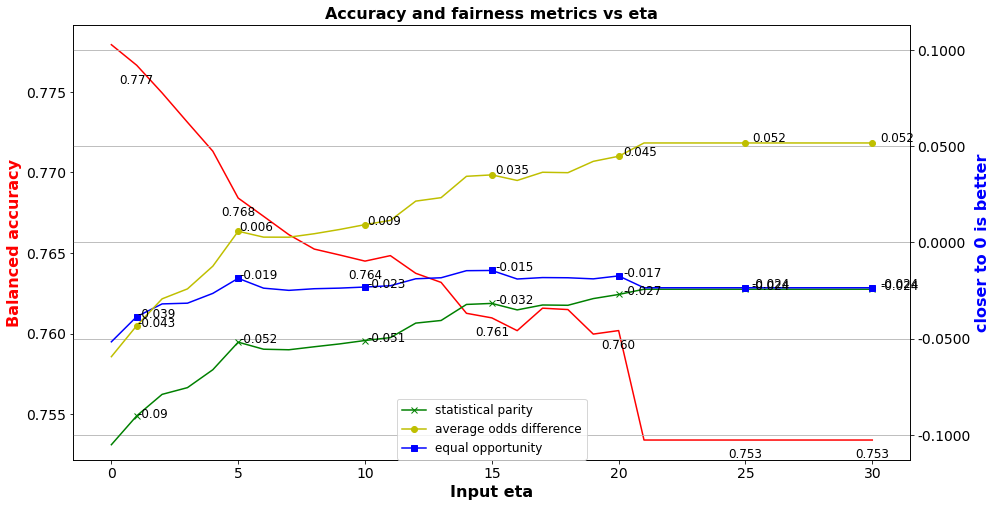

In [140]:
all_eta = np.linspace(0, 30, 31)
#metrics = [false_discovery_rates, statistical_rates, average_odds, disparate_impact, equal_opportunity]
metrics = {'statistical parity': ('x', statistical_rates, 'g'), 'average odds difference': ('o', average_odds, 'y'),\
           'equal opportunity': ('s', equal_opportunity, "b" )}

# 'false discovery rates': ('o', false_discovery_rates),
# 'disparate impact': ('+', disparate_impact),
display(Markdown("### Plot of accuracy and output fairness vs input constraint (eta)"))

display(Markdown("#### The graph illustrates the affect on fairness metrics for various values of eta"))

fig, ax1 = plt.subplots(figsize=(15,8))
ax1.plot(all_eta, accuracies, color='r')
ax1.set_title('Accuracy and fairness metrics vs eta', fontsize=16, fontweight='bold')
ax1.set_xlabel('Input eta', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced accuracy', color='r', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

for i in [1, 5, 10, 15, 20, 25, 30]:

    label = "{:.3f}".format(accuracies[i])

    plt.annotate(label,
                 (i, accuracies[i],),
                 textcoords="offset points",
                 xytext=(0,-18),
                 ha='center')

ax2 = ax1.twinx()
ax2.plot(all_eta,  statistical_rates, color='g')
ax2.plot(all_eta,  equal_opportunity, color='b')
ax2.plot(all_eta,  average_odds, color='y')
i = 0
for metric in metrics:
    for m in metrics[metric][1]:
        if i in [1, 5, 10, 15, 20, 25, 30]:
            plt.plot(all_eta[i], m, marker=metrics[metric][0], color=metrics[metric][2], label=metric if i == 1 else "")
            if i == 0:
                if metric != 'average odds difference':
                    plt.text(all_eta[i] * (1 + 0.01), m * (1 + 0.3) , round(m, 3), fontsize=12)
                else:
                    plt.text(all_eta[i] * (1 + 0.01), m * (1 + 0.01) , round(m, 3), fontsize=12)
            else:
                plt.text(all_eta[i] * (1 + 0.01), m * (1 + 0.01) , round(m, 3), fontsize=12)
        i = i + 1
    i = 0
    #plt.plot(all_eta, metrics[metric][1], metrics[metric][0], label=metric)
ax2.set_ylabel('closer to 0 is better', color='b', fontsize=16, fontweight='bold')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
#ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.1))


plt.rcParams.update({'font.size': 12})
plt.legend(loc='center', bbox_to_anchor=(0.5,0.07), numpoints=1)
yabs_max = abs(max(ax2.get_ylim(), key=abs))
ax2.set_ylim(ymin=-yabs_max, ymax=yabs_max)
ax2.grid(True)

plt.savefig("fairness_pr__roc_small.svg")

In [126]:
for i in range(31):
    print(f'{i} Accuracy: {accuracies[i]:9.4f}\
    St.parity: {statistical_rates[i]:9.4f}\
    Eq.opp: {equal_opportunity[i]:9.4f}\
    Eq.odds: {average_odds[i]:9.4f}\
    D_impact: {disparate_impact[i]:9.4f}')

0 Accuracy:    0.7779    St.parity:   -0.1052    Eq.opp:   -0.0517    Eq.odds:   -0.0594    D_impact:    0.8736
1 Accuracy:    0.7767    St.parity:   -0.0902    Eq.opp:   -0.0386    Eq.odds:   -0.0433    D_impact:    0.8914
2 Accuracy:    0.7749    St.parity:   -0.0790    Eq.opp:   -0.0320    Eq.odds:   -0.0294    D_impact:    0.9048
3 Accuracy:    0.7731    St.parity:   -0.0755    Eq.opp:   -0.0316    Eq.odds:   -0.0242    D_impact:    0.9091
4 Accuracy:    0.7713    St.parity:   -0.0662    Eq.opp:   -0.0265    Eq.odds:   -0.0124    D_impact:    0.9203
5 Accuracy:    0.7684    St.parity:   -0.0519    Eq.opp:   -0.0187    Eq.odds:    0.0058    D_impact:    0.9376
6 Accuracy:    0.7673    St.parity:   -0.0555    Eq.opp:   -0.0238    Eq.odds:    0.0027    D_impact:    0.9332
7 Accuracy:    0.7661    St.parity:   -0.0558    Eq.opp:   -0.0249    Eq.odds:    0.0027    D_impact:    0.9329
8 Accuracy:    0.7652    St.parity:   -0.0543    Eq.opp:   -0.0241    Eq.odds:    0.0045    D_impact:   

In [177]:
print(false_discovery_rates[20])

0.12615453931065557
